# ArtisticGAN by Jason Ohanaga

# Import libraries

In [1]:
import os
import time

from google.colab import drive
from google.colab import files

import numpy as np
import tensorflow as tf

import IPython.display as display
import matplotlib.pyplot as plt
import PIL.Image

# Download data

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!rsync --info=progress2 -az /content/gdrive/Shareddrives/ArtisticGAN/ Images
!ls

      1,735,784 100%  424.04kB/s    0:00:03 (xfr#11, to-chk=0/12)
gdrive	Images	sample_data


In [4]:
!mkdir NewImages
!ls Images

 composition-ix.jpg	        maltipoo+starry-night.jpg
 composition-vii.jpg	       'maltipoo+the-scream (1).jpg'
 impression.jpg		        maltipoo+the-scream.jpg
 maltipoo+composition-ix.jpg    starry-night.jpg
 maltipoo+composition-vii.jpg   the-scream.jpg
 maltipoo.jpg


# Utility functions

In [5]:
img_size = 512

In [6]:
def load_img(filepath):
  '''Takes the filepath of an image and decodes it'''

  image = tf.io.read_file(filepath)
  image = tf.io.decode_image(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) # this function scales then casts, floating point values are expected to have values [0,1]

  image = tf.image.resize(image, (img_size,img_size))
  image = image[tf.newaxis,:] # just like expand dim.. adds dim with a value of 1 at the front of the tensor for batch dim
  return image

In [7]:
def show(image, title=None):
  '''Displays an image'''

  if len(image.shape) > 3: # if batch dim remove it 
    image = tf.squeeze(image, axis=0) 

  plt.imshow(image)
  if title:
    plt.title(title)

In [8]:
def tensor_to_image(tensor):
  '''Converts a tensor to a PIL Image'''
  
  tensor = tensor*255.0
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3: # if the image tensor has a batch dimension
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [9]:
def clip_0_1(image):
  '''Image will be float so we need a function 
  to keep values in 0-1 range (normalized)'''

  return tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)

# Calculate style

The style of an image can be described by the means and correlations across the different feature maps. We must calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.

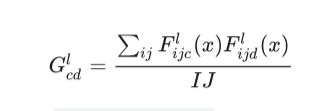


In [10]:

def gram_matrix(input_tensor):
  '''Calculates the 'style' of an image'''
  
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Build model

In [11]:
def vgg_layers(layer_names):
  '''Gets desired output layers of the VGG model'''

  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
  return model

In [12]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]
                
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
class StyleContentModel(tf.keras.models.Model):
  '''Our model is an extractor that obtains the style and the content of an input'''

  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.model = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False

  def call(self, inputs):
    '''model returns gram matrix (style calculator) of style layer and content of content layers'''
    
    inputs = inputs*255 # input is float [0,1] so turn back to int [0,255] for preprocessing
    inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    
    outputs = self.model(inputs)
    style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    style_dict = {style_name: output for style_name, output in zip(self.style_layers, style_outputs)}

    content_dict = {content_name: output for content_name, output in zip(self.content_layers, content_outputs)}

    return {'content': content_dict, 'style': style_dict}
    

# Loss function

In [14]:
style_weight = 1e-1
content_weight = 1e1

print("Current style/content ratio:", style_weight/content_weight)
print("Changing style/content ratio will result in different images as noted in article linked in README")

Current style/content ratio: 0.01
Changing style/content ratio will result in different images as noted in article linked in README


In [15]:
def calc_loss(outputs, style_targets, content_targets):
  '''Loss function of our model - determine loss between 
  generated style/content and target style/content'''

  gen_style_outputs = outputs['style']
  gen_content_outputs = outputs['content']

  style_loss = tf.add_n([tf.reduce_mean((gen_style_outputs[name]-style_targets[name])**2) for name in gen_style_outputs.keys()])
  style_loss *= style_weight/ num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((gen_content_outputs[name]-content_targets[name])**2) for name in gen_content_outputs.keys()])
  content_loss *= content_weight/ num_content_layers

  loss = style_loss + content_loss
  return loss

# Get images

In [16]:
!ls Images

 composition-ix.jpg	        maltipoo+starry-night.jpg
 composition-vii.jpg	       'maltipoo+the-scream (1).jpg'
 impression.jpg		        maltipoo+the-scream.jpg
 maltipoo+composition-ix.jpg    starry-night.jpg
 maltipoo+composition-vii.jpg   the-scream.jpg
 maltipoo.jpg


In [17]:
dir_path = 'Images/'
content_path = dir_path+'maltipoo.jpg'
style_path = dir_path+'starry-night.jpg'

Shape of content image (1, 512, 512, 3)
Shape of style image (1, 512, 512, 3)


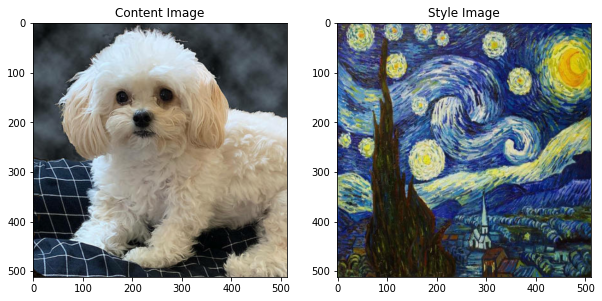

In [18]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
show(content_image, 'Content Image')
print("Shape of content image",content_image.shape)

plt.subplot(1, 2, 2)
show(style_image, 'Style Image')
print("Shape of style image", style_image.shape)

# Run model

In [19]:
extractor = StyleContentModel(style_layers, content_layers) # build model

style_targets = extractor(style_image)['style'] # call model on style image to get target style

content_targets = extractor(content_image)['content'] # call model on content image to get target content

image = tf.Variable(content_image) # create tf variable instantiated with content image that will be the editted image for our model

80142336/80134624 [==============================] - 1s 0us/step


In [20]:
total_var_weight = 10 # This basic implementation produces a lot of high frequency artifacts. 
                      # To decrease them, we will use an explicit regularization term on the high frequency components of the image.

opt = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.99, epsilon=1e-1) # model optimizer

In [21]:
@tf.function
def train_step(image):
  '''Decorater is used because it helps create performant and 
  portable models, and it is required to use SavedModel.'''

  with tf.GradientTape() as tape:
    outputs = extractor(image) # run image thru model
    loss = calc_loss(outputs, style_targets, content_targets) # calc loss
    loss += total_var_weight*tf.image.total_variation(image) # calc total loss with variation

  grad = tape.gradient(loss, image) # gradient descent
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image)) # upadte image

def train_model():
  '''Custom training loop'''

  start = time.time()
  epochs = 50
  steps_per_epoch = 200
  step = 0

  for e in range(epochs):
    for s in range(steps_per_epoch):
      step += 1
      train_step(image)
      print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Epoch: {}".format(e+1))

  end = time.time()
  print("Total time elasped: {:.1f} seconds".format(end-start))

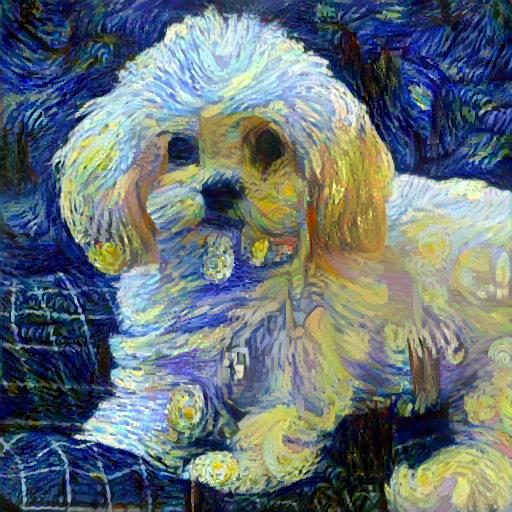

Epoch: 50
Total time elasped: 429.1 seconds


In [22]:
train_model()